## Downscaling Experiment (4 years)

### Boring Stuff

##### Imports

In [3]:

from IPython.display import display
import tensorflow as tf
import os
import numpy as np
import xarray as xr

from visualization.climate_data_visualizer import ClimateDataVisualizer
from visualization.evaluation_visualizer import EvaluationVisualization
from downscaling.pipeline import DownscalingPipeline
from utility.utility import save_to_json, store_to_disk, load_via_url, split_data
from model.modelconfig import UNetModelConfiguration
from utility.data_generator import DataGenerator

%reload_ext autoreload
%autoreload 2


config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
tf.compat.v1.Session(config=config)

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

##### Settings

In [4]:
data_path = './data/'
result_path=('./results/')
stats_file = './config/climatology_stats_4y.json'

file_era = 'data/era5_preprocessed_standardized_anomalies_4y.nc'
file_cerra = 'data/cerra_preprocessed_standardized_anomalies_4y.nc'


### Loading Preprocessed Data

In [5]:
preprocessed_lr_data = xr.open_dataset(file_era)
preprocessed_hr_data = xr.open_dataset(file_cerra)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### Data Splitting

In [6]:
lr_train_data, lr_val_data, lr_test_data, hr_train_data, hr_val_data, hr_test_data = split_data(preprocessed_lr_data, preprocessed_hr_data)

train_data = [lr_train_data, hr_train_data]
val_data = [lr_val_data, hr_val_data]
test_data = [lr_test_data, hr_test_data]

### Utility Functionality for Running the Model 

In [7]:
def run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix):
    pipeline = DownscalingPipeline(normalization_type)

    train_data_generator = DataGenerator(train_data[0], train_data[1], model_setup['batch_size'])
    val_data_generator = DataGenerator(val_data[0], val_data[1], model_setup['batch_size'])

    model = pipeline.fit_model(
        train_generator = train_data_generator,
        val_generator = val_data_generator,
        scheduler_type = model_setup['scheduler_type'],
        learning_rate_value = model_setup['learning_rate_value'],
        num_epochs = model_setup['num_epochs'],
        loss_type = model_setup['loss_type'],
        filters = model_setup['filters']
        #show_summary = True
    )

    pipeline.show_training_history(filename_suffix)

    # Predict unseen data
    result = pipeline.predict(lr_test_data, stats_file)

    # evaluate predicted data
    hr_test_denormalized = pipeline.denormalize(hr_test_data, stats_file)
    metric_results = pipeline.evaluate_prediction(hr_test_denormalized, result)

    visualizer = EvaluationVisualization()
    visualizer.spatial_plots(hr_test_denormalized, result, filename_suffix)
    visualizer.difference_maps(hr_test_denormalized, result, filename_suffix)
    visualizer.histograms(hr_test_denormalized, result, filename_suffix)

    history = pipeline.get_history()
    save_to_json(filename_suffix, model_setup, history['loss'], history['val_loss'], metric_results)    

### Hyperparameter Optimization

#### Parameter Setting

In [8]:
filename_suffix = ''
last_idx = 100

normalization_types = ['standardized_anomalies', 'min_max']
scheduler_types = ['step_decay', 'exponential_decay', 'time_decay'] 
learning_rate_values = [1e-1, 1e-2, 1e-3, 1e-4]
loss_types = ['mse', 'mae', 'huber_loss'] 
num_epochs_list = [4, 10, 15, 20, 30, 50]
batch_sizes = [8, 16, 32, 64]
initial_filters = [16, 32, 56, 64]

model_configuration = UNetModelConfiguration()

### Hyperparameter Optimization for Standardized Anomalies

Epoch 1/4
36/36 [==============================] - 2994s 83s/step - loss: 0.1358 - val_loss: 0.0796 - lr: 0.0010
Epoch 2/4
36/36 [==============================] - 2944s 84s/step - loss: 0.0922 - val_loss: 0.0566 - lr: 0.0010
Epoch 3/4
36/36 [==============================] - 2992s 83s/step - loss: 0.0878 - val_loss: 0.0421 - lr: 0.0010
Epoch 4/4
36/36 [==============================] - 2832s 79s/step - loss: 0.0869 - val_loss: 0.0413 - lr: 0.0010


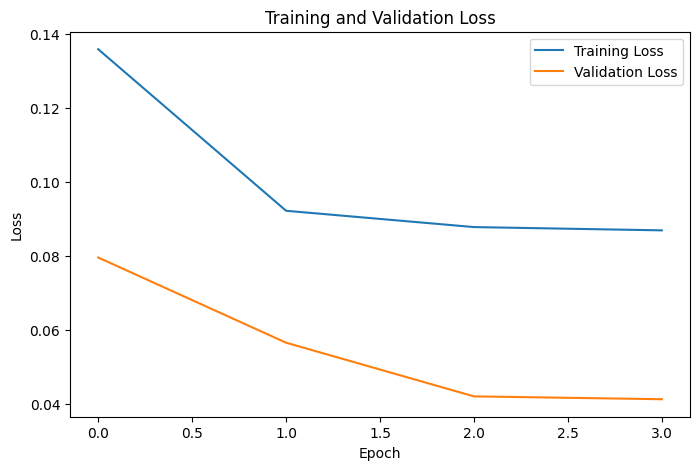

6/6 [==============================] - 103s 16s/step

Metrics:
╒════════╤═════════╤═════════════╤═════════╕
│   RMSE │     MAE │   Max Error │    Bias │
╞════════╪═════════╪═════════════╪═════════╡
│ 3.3615 │ 2.34155 │     26.3399 │ 0.36447 │
╘════════╧═════════╧═════════════╧═════════╛


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


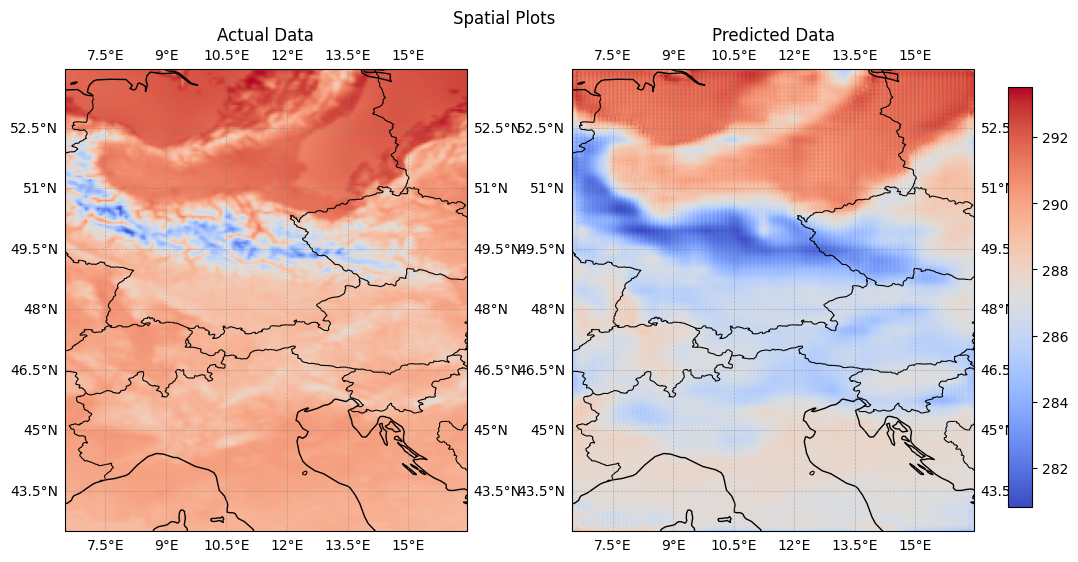

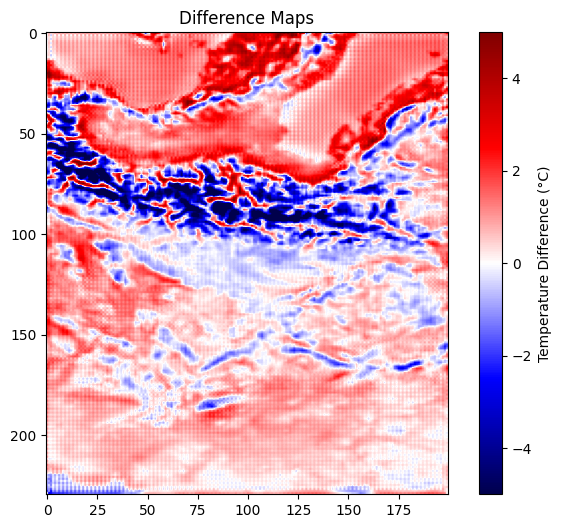

[300.0521  300.05112 300.03256 ... 275.35706 275.11877 274.9215 ]
[293.5657  294.593   294.60773 ... 278.07446 278.04733 278.23032]


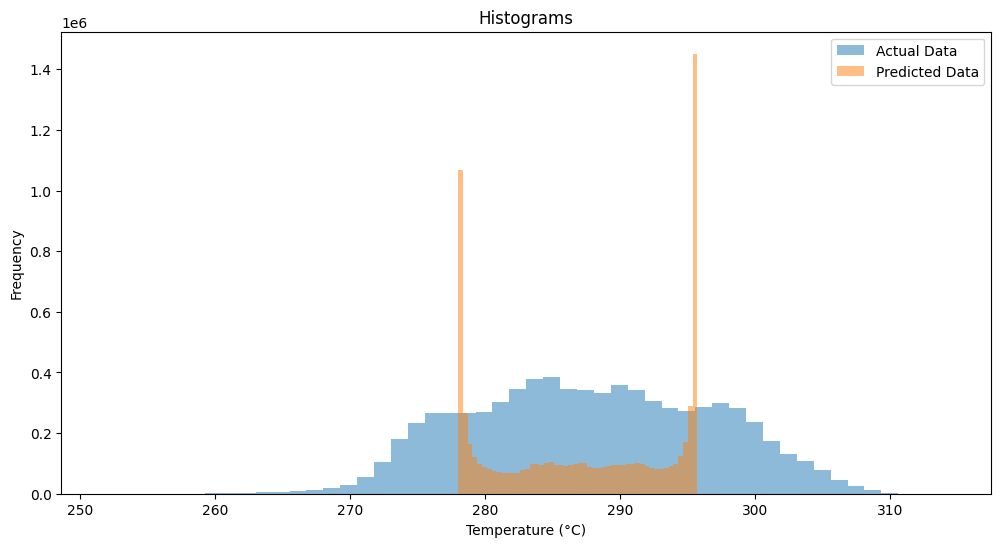

In [16]:
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[0]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[0]
batch_size = batch_sizes[2]
loss_type = loss_types[2] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area, with batch normalization'
}


# ------------ step_decay ------------
#model_setup['scheduler_type'] = scheduler_types[0]

filename_suffix = 'sa_testing_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1

#### Try different scheduler types
Need +10 epochs so it works out 

In [10]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[0]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[2] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ step_decay ------------
model_setup['scheduler_type'] = scheduler_types[0]

filename_suffix = 'sa_scheduler_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ exponential_decay ------------
model_setup['scheduler_type'] = scheduler_types[1]

filename_suffix = 'sa_scheduler_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ time_decay ------------
model_setup['scheduler_type'] = scheduler_types[2]
filename_suffix = 'sa_scheduler_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1

Epoch 1/20


KeyboardInterrupt: 

#### Testing different loss types

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ mse ------------
model_setup['loss_type']=loss_types[0] 

filename_suffix = 'sa_loss_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ mae ------------
model_setup['loss_type']=loss_types[1] 


filename_suffix = 'sa_loss_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ huber_loss ------------
model_setup['loss_type']=loss_types[2] 

filename_suffix = 'sa_loss_type_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

#### Testing different batch sizes

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ 8 ------------
model_setup['batch_size']=batch_sizes[0] 

filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 16 ------------
model_setup['batch_size']=batch_sizes[1] 


filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 32 ------------
model_setup['batch_size']=batch_sizes[2] 

filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1


# ------------ 64 ------------
model_setup['batch_size']=batch_sizes[3] 

filename_suffix = 'sa_batch_size_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

#### Testing different learning rates

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ 1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[0] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------  1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[1] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[2] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1


# ------------ 1e-4 ------------
model_setup['learning_rate_value']=learning_rate_values[3] 

filename_suffix = 'sa_learn_rate_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

#### Testing different filters

In [ ]:
# base settings
normalization_type = normalization_types[0]
scheduler_type = scheduler_types[1]
learning_rate_value = learning_rate_values[2]
num_epochs = num_epochs_list[3]
batch_size = batch_sizes[2]
loss_type = loss_types[0] 
initial_filter = initial_filters[1]
filters = model_configuration.generate_filters(initial_filter)
last_idx=0

model_setup = {
    'scheduler_type': scheduler_type,
    'learning_rate_value': learning_rate_value,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'loss_type': loss_type,
    'filters': filters,
    'activation_function': 'tanh', 
    'note': '4y, cropped area'
}


# ------------ 16 ------------
model_setup['filters']=filters[0] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------  32 ------------
model_setup['filters']=filters[1] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1



# ------------ 56 ------------
model_setup['filters']=filters[2] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)
last_idx += 1


# ------------ 64 ------------
model_setup['filters']=filters[3] 

filename_suffix = 'sa_filters_'+str(last_idx)
run_model_pipeline(normalization_type, train_data, val_data, model_setup, filename_suffix)

### Hyperparametr Optimization for Min Max

fewer tests ?